# Predict Rhematoid Arthritis

### Introduction

Rheumatoid arthritis is a chronic inflammatory disorder that can affect more than just your joints. In some people, the condition can damage a wide variety of body systems, including the skin, eyes, lungs, heart and blood vessels.

### Problem Statement

Identifying the patients at risk of Rheumatoid Arthritis (RA): Early diagnosis

### Approach

Analyze EMR and develop a model which will predict whether a patient with given demographics and symptoms such as : Joint Pain, Joint Stiffness, Fatigue, Fever is susceptible to be diagnosed with Rheumatoid Arthritis (RA)

### Type of Features considered:

1) Demographics - It contains patient level demographic data such as Age, Race and Gender etc

2) Diagnosis - It contains data about the several conditions the patient has been diagnosed with

3) Observations - It contains lab measurement details of the patients

4) Prescriptions - It contains drug details administered to the patients

#### Packages that are need to be imported

In [ ]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,auc,log_loss,precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as se
from sklearn.utils import shuffle
import math
from sklearn import linear_model
from scipy.stats import uniform
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import sklearn
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

#### DATA PREPARATION

In [15]:
%%time
#Create Engine for Redshift to get data from Database proxi
engine = psycopg2.connect(dbname='xxx', host='xxxx', port='xxx',user='xxx', password='xxxx')

#Extracting top 15K patient id,date_of_birth,race,gender from patients table
demo = pd.read_sql('''select id as person_id,date_of_birth,race,gender FROM "proxi_v6"."patients" limit 10000;''',con=engine)

#Find current age from date_of_birth column and delete date_of_birth column
demo['date_of_birth'] = pd.to_datetime(demo['date_of_birth'])
now = datetime.now()
demo['age'] = (now - demo['date_of_birth']).astype('<m8[Y]')
demo = demo.drop(['date_of_birth'],axis=1)
#To use patients_id in the SQL query, we have to convert patients id into String format
patients_id = str(tuple(demo['person_id'].tolist()))

#Extracting observations of RA patients Based on Diagnosis code and onset date in condition table.
ra_obs = pd.read_sql("""select a.* from 
(SELECT person_id,start,code,value,type FROM "proxi_v6"."observations")a, 
(SELECT person_id,start FROM  "proxi_v6"."conditions" where upper(code) like ('M08%'))c 
where a.person_id in """+patients_id+""" and a.person_id = c.person_id and to_date(a.start,'dd-mm-yyyy') <= dateadd(year, -1, to_date(c.start,'dd-mm-yyyy'));""",con=engine)

ra_obs_id_list = ra_obs['person_id'].unique().tolist()

#set RAflag as 1 for RA patients
demo_ra = demo[demo.person_id.isin(ra_obs_id_list)]
demo_ra.insert(1,'RAflag',1)
#set RAflag as 0 for NON_RA patients
demo_non_ra = demo[~demo.person_id.isin(ra_obs_id_list)]
demo_non_ra.insert(1,'RAflag',0)
#append Dataframe RA and NON_RA
demo_with_flag = demo_ra.append(demo_non_ra,ignore_index=True)

#Extracting observations of NON_T2D patients Based on Diagnosis code in condition table.
non_ra_obs = pd.read_sql("""select a.* from 
(SELECT person_id,code,start,value,type FROM "proxi_v6"."observations")a, 
(SELECT person_id FROM  "proxi_v6"."conditions" where upper(code) not like ('M08%'))c 
where a.person_id in """+patients_id+""" and a.person_id = c.person_id ;""",con=engine)

#append Dataframe ra_obs and non_ra_obs
observations = ra_obs.append(non_ra_obs,ignore_index=True)

observations = observations[observations['type'] == 'numeric']
observations['value']=observations['value'].astype('float')
observations.rename(columns={'start':'date'}, inplace=True)

observations = observations.sort_values(['person_id','code','date'],ascending=False)
observations.reset_index(inplace=True,drop=True)
observations = observations.groupby(['person_id','code']).head(3)
obs_temp_agg_mean = observations[['person_id','code','value']].groupby(['person_id','code']).agg({'value': "mean"}).reset_index()
# Get the mean CV observations for the duration of the condition 
observations_agg_mean_pivot = obs_temp_agg_mean.pivot(index='person_id',columns='code',values='value').reset_index()

ra_med = pd.read_sql("""select a.* from 
(SELECT person_id,start,code FROM "proxi_v6"."medications")a, 
(SELECT person_id,start FROM  "proxi_v6"."conditions" where upper(code) like ('M08%'))c 
where a.person_id in """+patients_id+""" and a.person_id = c.person_id and to_date(a.start,'dd-mm-yyyy') <= dateadd(year, -1, to_date(c.start,'dd-mm-yyyy'));""",con=engine)

%%time
non_ra_med = pd.read_sql("""select a.* from 
(SELECT person_id,start,code FROM "proxi_v6"."medications")a, 
(SELECT person_id FROM  "proxi_v6"."conditions" where upper(code) not like ('M08%'))c 
where a.person_id in """+patients_id+""" and a.person_id = c.person_id ;""",con=engine)

#append Dataframe ra_obs and non_ra_obs
medications = ra_med.append(non_ra_med,ignore_index=True)

medications.insert(3,'value',1)
medications_agg = medications[['person_id','code','value']].groupby(['person_id','code']).agg({'value':'count'}).reset_index()
#Creating features by pivot the table
medications_pivot = medications_agg.pivot(index='person_id',columns='code',values='value').reset_index()
#zero imputation
medications_pivot = medications_pivot.fillna(0)

observations_demo = pd.merge(observations_agg_mean_pivot,demo_with_flag,on='person_id',how='inner')
rheumatoid_arthritis = pd.merge(observations_demo,medications_pivot,on='person_id',how='inner')

CPU times: user 28min 30s, sys: 2min 54s, total: 31min 25s
Wall time: 35min 39s


#### DATA PREPROCESSING

In [141]:
%%time
rheumatoid_arthritis['race'] = rheumatoid_arthritis['race'].astype('str')
rheumatoid_arthritis['gender'] = rheumatoid_arthritis['gender'].astype('str')
#Label encoding to the categorical column gender
le = LabelEncoder()
rheumatoid_arthritis["gender"] = le.fit_transform(rheumatoid_arthritis["gender"])
rheumatoid_arthritis["race"] = le.fit_transform(rheumatoid_arthritis["race"])
cols = list(rheumatoid_arthritis.columns)
remove = ['person_id', 'RAflag', 'gender', 'age','race']
CV_contFeatures = [x for x in cols if x not in remove]
age_grp_ci = [-1,29,39,49,59,69,110]
#Mean Imputation on CV
def meanImputation(df,CVFeatures,age_grp):
    d = pd.DataFrame()
    for cv in CVFeatures:
        for i in range(len(age_grp)-1):
            for j in range(2):
                value =df[(df['age']>age_grp[i])&(df['age']<=age_grp[i+1])&(df['gender']==j)][cv].mean()
                temp = df[(df['age']>age_grp[i])&(df['age']<=age_grp[i+1])&(df['gender']==j)]
                if (math.isnan(value)):
                    temp[cv] = temp[cv].fillna(0)
                else:
                    temp[cv] = temp[cv].fillna(value)
                d = pd.concat([d,temp],axis=0)
        df = d.copy()
        d = pd.DataFrame()
    return df
rheumatoid_arthritis = meanImputation(rheumatoid_arthritis,CV_contFeatures,age_grp_ci)
rheumatoid_arthritis = rheumatoid_arthritis.sort_index()
del rheumatoid_arthritis['person_id']
#Moving predicting columns at the last
df_new= rheumatoid_arthritis.pop('RAflag')
rheumatoid_arthritis['target']=df_new
rheumatoid_arthritis.rename(columns={'target':'RAflag'}, inplace=True)
ra = rheumatoid_arthritis

CPU times: user 7min 16s, sys: 0 ns, total: 7min 16s
Wall time: 7min 31s


#### FEATURES CORRELATION

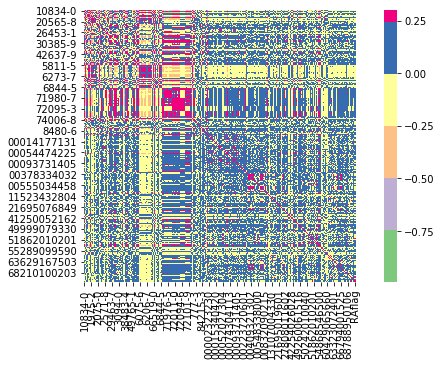

In [184]:
ra['RAflag'] = ra['RAflag'].astype(int)
feature_corr = ra.corr()
plt.subplots(figsize=(10,5))
feature_map = se.heatmap(feature_corr, cmap='Accent', center=0, vmax=.3, square=True)
plt.show()

In [185]:
ra.RAflag.value_counts()

0    9745
1      41
Name: RAflag, dtype: int64

#### Features Selection Using f_classif

In this usecase we have done feature selection using f_classif feature selection method.
f_classif method gives p-values as one of it's result, using this p-values we are selecting the significant features 

In [364]:
df = rheumatoid_arthritis
X_train,X_test,y_train,y_test = train_test_split(df.drop(['RAflag'],axis=1),df['RAflag'],random_state=20,test_size=0.3)
values = sklearn.feature_selection.f_classif(X_train, y_train) 
pvalue = []
indexes = []
for x,i in zip(values[1],range(len(X_train))):
    if x < 0.05:
        pvalue.append(x)
        indexes.append(i) 
columns = []
for i in indexes:
    columns.append(X_train.columns[i])
columns.append('RAflag')

#One hot encoding to the race categorical colulmn
if 'race' in columns:
    raceDummies_train = pd.get_dummies(X_train_selected['race'], prefix = 'race')
    X_train_selected = pd.concat([X_train_selected, raceDummies_train], axis=1)
    raceDummies_test = pd.get_dummies(X_test_selected['race'], prefix = 'race')
    X_test_selected = pd.concat([X_test_selected, raceDummies_test], axis=1)
    del X_train_selected['race']
    del X_test_selected['race']
df1 = df[columns]

#### BALANCING DATA

Our data is imbalanced, so we are going 
perform over-sampling using Adaptive Synthetic (ADASYN) sampling approach for imbalanced datasets.

In [374]:
x = df1.drop(['RAflag'],axis=1)
y = df1.filter(['RAflag'])
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.4)
x_train = x_train.values
y_train = y_train.values
synthetic_features_ADASYN = ADASYN(random_state=0, ratio={0:9786,1:1200})
X_ADASYN, Y_ADASYN = synthetic_features_ADASYN.fit_sample(x_train,y_train.ravel())
print(np.unique(Y_ADASYN,return_counts=True))

(array([0, 1]), array([9787, 1208]))


In [375]:
print("Length of X is", len(X_ADASYN))
print("Length of Y is", len(Y_ADASYN))

Length of X is 10995
Length of Y is 10995


#### MODEL SELECTION

In [376]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
xgbc = XGBClassifier()
model_list = []
model_list.append(('LR',lr))
model_list.append(('DTC',dtc))
model_list.append(('RFC',rfc))
model_list.append(('ABC',abc))
model_list.append(('GBC',gbc))
model_list.append(('xgbc',xgbc))
modelname = []
modelaccuracy = []
model_roc_auc_score = []
model_precision_score = []
model_recall_score = []
for model_name,select_model in model_list:
    fit_model = select_model.fit(X_ADASYN,Y_ADASYN)
    model_predict = fit_model.predict(x_test.values)
    model_accuracy = accuracy_score(y_test,model_predict)
    probability_1 = select_model.predict_proba(x_test.values)[:,1]
    roc_auc_score_model = roc_auc_score(y_test,probability_1)
    precision_score_model = precision_score(y_test,model_predict)
    recall_score_model = recall_score(y_test,model_predict)
    model_msg = "%s - Accuracy: %f AUC: %f Precision: %f Recall: %f" % (model_name, model_accuracy, roc_auc_score_model, precision_score_model,recall_score_model)
    modelname.append(model_name)
    modelaccuracy.append(model_accuracy)
    model_roc_auc_score.append(roc_auc_score_model)
    model_precision_score.append(precision_score_model)
    model_recall_score.append(recall_score_model)
    print(model_msg)
    cm =confusion_matrix(y_test,model_predict)
    print("cm = ",cm)

LR - Accuracy: 0.991571 AUC: 0.801703 Precision: 0.342105 Recall: 0.619048
cm =  [[3869   25]
 [   8   13]]
DTC - Accuracy: 0.998212 AUC: 0.857014 Precision: 0.937500 Recall: 0.714286
cm =  [[3893    1]
 [   6   15]]
RFC - Accuracy: 0.996169 AUC: 0.999450 Precision: 0.875000 Recall: 0.333333
cm =  [[3893    1]
 [  14    7]]
ABC - Accuracy: 0.997701 AUC: 0.998459 Precision: 0.928571 Recall: 0.619048
cm =  [[3893    1]
 [   8   13]]
GBC - Accuracy: 0.998978 AUC: 0.999609 Precision: 0.947368 Recall: 0.857143
cm =  [[3893    1]
 [   3   18]]
xgbc - Accuracy: 0.999234 AUC: 0.999743 Precision: 0.950000 Recall: 0.904762
cm =  [[3893    1]
 [   2   19]]


Text(0.5, 1.0, 'Accuracy of a model')

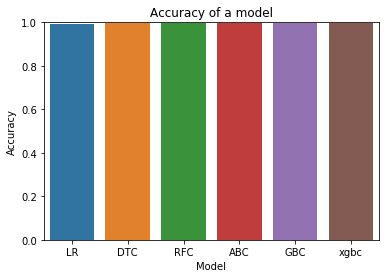

In [377]:
bar_plot = se.barplot(x=modelname,y=modelaccuracy)
bar_plot.set_ylim(0,1)
bar_plot.set_ylabel("Accuracy")
bar_plot.set_xlabel("Model")
bar_plot.set_title("Accuracy of a model")

#### MODEL EVALUATE

In [378]:
models = []
models.append(('LR',LogisticRegression()))
models.append(('DTC',DecisionTreeClassifier()))
models.append(('RFC',RandomForestClassifier()))
models.append(('ABC',AdaBoostClassifier()))
models.append(('GBC',GradientBoostingClassifier()))
models.append(('xgbc',XGBClassifier()))
model_results = []
model_name = []
model_score = []
for name, model in models:
    kfold_validation = model_selection.KFold(n_splits=10, random_state=0)
    cv_results = model_selection.cross_val_score(model, X_ADASYN, Y_ADASYN.ravel(), cv=kfold_validation, scoring='accuracy')
    model_results.append(cv_results)
    model_name.append(name)
    model_score.append(cv_results.mean())
    msg = "%s Mean: %f standard Deviation: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR Mean: 0.945589 standard Deviation: 0.108567
DTC Mean: 0.995815 standard Deviation: 0.008440
RFC Mean: 0.979982 standard Deviation: 0.051617
ABC Mean: 0.999545 standard Deviation: 0.000838
GBC Mean: 0.995633 standard Deviation: 0.011616
xgbc Mean: 0.999545 standard Deviation: 0.000838


(0.5, 1)

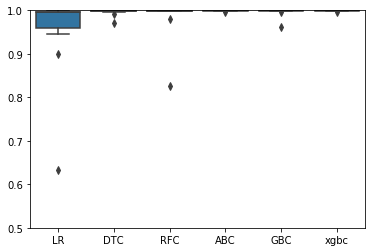

In [379]:
boxplot_cv = se.boxplot(x=model_name, y=model_results)
boxplot_cv.set_ylim(0.5,1)

### Model Building for GradientBoostingClassifier

In [395]:
xgbc_model = XGBClassifier()
xgbc_fit = xgbc_model.fit(X_ADASYN, Y_ADASYN)
xgbc_predict = xgbc_fit.predict(x_test.values)
xgbc_accuracy = accuracy_score(y_test,xgbc_predict)
probability_1 = xgbc_model.predict_proba(x_test.values)[:,1]
xgbc_roc_score = roc_auc_score(y_test,probability_1)
xgbc_predict_train_data = xgbc_fit.predict(x_train)
probability1_1 = xgbc_model.predict_proba(x_test.values)[:,1]
xgbc_accuracy_train_data = accuracy_score(y_train,xgbc_predict_train_data)
xgbc_roc_score_train_data = roc_auc_score(y_train, xgbc_predict_train_data)
print("Accuracy on test data is %f" % (xgbc_accuracy))
print("ROC_AUC Score for test data is %f" % (xgbc_roc_score))
print("Accuracy on train data is %f" % (xgbc_accuracy_train_data))
print("ROC_AUC Score for train data is %f" % (xgbc_roc_score_train_data))

Accuracy on test data is 0.999234
ROC_AUC Score for test data is 0.999743
Accuracy on train data is 0.999830
ROC_AUC Score for train data is 0.999915


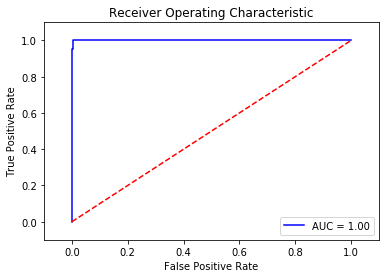

In [401]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probability_1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate, 'b' ,label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# END